In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data/LOG_CHESTXRAY.pdf
/kaggle/input/data/README_CHESTXRAY.pdf
/kaggle/input/data/BBox_List_2017.csv
/kaggle/input/data/test_list.txt
/kaggle/input/data/ARXIV_V5_CHESTXRAY.pdf
/kaggle/input/data/Data_Entry_2017.csv
/kaggle/input/data/train_val_list.txt
/kaggle/input/data/FAQ_CHESTXRAY.pdf
/kaggle/input/data/images_003/images/00006199_010.png
/kaggle/input/data/images_003/images/00004833_016.png
/kaggle/input/data/images_003/images/00006260_000.png
/kaggle/input/data/images_003/images/00004911_010.png
/kaggle/input/data/images_003/images/00004186_007.png
/kaggle/input/data/images_003/images/00004459_000.png
/kaggle/input/data/images_003/images/00005004_001.png
/kaggle/input/data/images_003/images/00005757_000.png
/kaggle/input/data/images_003/images/00004221_001.png
/kaggle/input/data/images_003/images/00004875_000.png
/kaggle/input/data/images_003/images/00005448_001.png
/kaggle/input/data/images_003/images/00005572_000.png
/kaggle/input/data/images_003/images/00005271_00

KeyboardInterrupt: 

In [3]:
cd /kaggle/input/data

/kaggle/input/data


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Collect all image names from all 10 folders
base_path = '/kaggle/input/data'  # Update with correct base path
all_img_files = []
for i in range(1, 11):
    folder = f'images_{i:03}/images'
    folder_path = os.path.join(base_path, folder)
    files = os.listdir(folder_path)
    all_img_files.extend(files)

# Load CSV and filter to only images that exist in all folders (sanity check)
df = pd.read_csv('Data_Entry_2017.csv')
df = df[df['Image Index'].isin(all_img_files)]
label_counts = df['Finding Labels'].value_counts()
valid_labels = label_counts[label_counts > 1].index.tolist()

# Filter DataFrame to only these classes
df_valid = df[df['Finding Labels'].isin(valid_labels)]
# Stratified sampling
desired_size = 20000
df_stratified, _ = train_test_split(
    df_valid, 
    test_size=(len(df_valid)-desired_size), 
    stratify=df_valid['Finding Labels'], 
    random_state=42
)

# Optional: Check label distribution
print(df['Finding Labels'].value_counts(normalize=True))
print(df_stratified['Finding Labels'].value_counts(normalize=True))




Finding Labels
No Finding                                                                0.543332
Infiltration                                                              0.080769
Atelectasis                                                               0.038158
Effusion                                                                  0.034916
Nodule                                                                    0.024074
                                                                            ...   
Effusion|Infiltration|Mass|Nodule|Pneumonia                               0.000011
Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Pneumonia    0.000011
Consolidation|Hernia|Infiltration|Pneumonia                               0.000011
Atelectasis|Fibrosis|Infiltration|Mass|Nodule                             0.000011
Effusion|Hernia|Mass|Pleural_Thickening                                   0.000011
Name: proportion, Length: 785, dtype: float64
Finding Labels
No Finding 

In [6]:
df_stratified.shape

(20000, 12)

In [7]:
df_stratified['Finding Labels'].value_counts()

Finding Labels
No Finding                                                   10902
Infiltration                                                  1621
Atelectasis                                                    766
Effusion                                                       701
Nodule                                                         483
                                                             ...  
Edema|Infiltration|Pleural_Thickening|Pneumonia                  1
Atelectasis|Effusion|Nodule|Pneumothorax                         1
Atelectasis|Mass|Nodule|Pleural_Thickening                       1
Emphysema|Infiltration|Pleural_Thickening|Pneumothorax           1
Atelectasis|Consolidation|Effusion|Emphysema|Infiltration        1
Name: count, Length: 390, dtype: int64

In [8]:
# Set your minimum required count for each class/label combination
min_examples = 100  # Try 5 or 10

# Find label combinations with at least min_examples images
label_counts = df_stratified['Finding Labels'].value_counts()
valid_labels = label_counts[label_counts >= min_examples].index.tolist()

# Filter dataframe
df_filtered = df_stratified[df_stratified['Finding Labels'].isin(valid_labels)]

# Now proceed to stratified sampling only on df_filtered


In [9]:
df_filtered['Finding Labels'].value_counts().describe()

count       18.000000
mean       960.833333
std       2507.375479
min        117.000000
25%        170.500000
50%        239.000000
75%        460.500000
max      10902.000000
Name: count, dtype: float64

In [10]:
import pandas as pd

# Your current subset and the full dataset
df_subset = df_filtered.copy()
df_full = df_valid.copy()

# This step ensures no "Image Index" duplication between df_subset and df_full pool for extra sampling
used_imgs = set(df_subset['Image Index'])

min_count = 239  # median of count 
labels = df_subset['Finding Labels'].unique()

for label in labels:
    # Number present in your current subset
    current_count = df_subset[df_subset['Finding Labels'] == label].shape[0]
    if current_count < min_count:
        n_needed = min_count - current_count
        
        # Find candidates in the full data, not already present in the subset
        candidates = df_full[
            (df_full['Finding Labels'] == label) &
            (~df_full['Image Index'].isin(used_imgs))
        ]
        if not candidates.empty:
            to_add = candidates.sample(n=min(n_needed, candidates.shape[0]), random_state=42)
            df_subset = pd.concat([df_subset, to_add], ignore_index=True)
            used_imgs.update(to_add['Image Index'])

# Optional: shuffle subset
df_subset = df_subset.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new balance
print(df_subset['Finding Labels'].value_counts())


Finding Labels
No Finding                           10902
Infiltration                          1621
Atelectasis                            766
Effusion                               701
Nodule                                 483
Mass                                   393
Pneumothorax                           370
Effusion|Infiltration                  269
Atelectasis|Infiltration               241
Pleural_Thickening                     239
Atelectasis|Effusion                   239
Cardiomegaly                           239
Consolidation                          239
Edema                                  239
Fibrosis                               239
Emphysema                              239
Atelectasis|Effusion|Infiltration      239
Infiltration|Nodule                    239
Name: count, dtype: int64


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split


df_trainval, df_test = train_test_split(df_subset, test_size=0.2, stratify=df_subset['Finding Labels'], random_state=42)
# Then split train into train and val (e.g. 80/20 of train)
df_train, df_val = train_test_split(df_trainval, test_size=0.2, stratify=df_trainval['Finding Labels'], random_state=42)




In [35]:
# Identify unique labels (multi-label)
all_labels = sorted({l for x in df['Finding Labels'] for l in x.split('|')})

# Function to convert label string to one-hot array
def encode_labels(label_str):
    labels = label_str.split('|')
    return [int(lbl in labels) for lbl in all_labels]

for split in [df_train, df_val, df_test]:
    split['onehot'] = split['Finding Labels'].apply(encode_labels)


In [36]:
len(all_labels)

15

In [14]:
df_train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,onehot
13547,00022065_003.png,Atelectasis|Effusion|Infiltration,3,22065,47,M,PA,2992,2991,0.143,0.143,NaN,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
5830,00011941_001.png,No Finding,1,11941,27,F,PA,2526,2309,0.143,0.143,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
10702,00016103_009.png,No Finding,9,16103,65,M,PA,2878,2991,0.143,0.143,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
5804,00023749_000.png,No Finding,0,23749,39,M,PA,2826,2677,0.143,0.143,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
15653,00013055_004.png,No Finding,4,13055,69,M,AP,2500,2048,0.168,0.168,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [15]:
base_path = '/kaggle/input/data'  # Update with correct base pat
all_img_paths={}
for i in range(1, 11):
    folder = f'images_{i:03}/images'
    folder_path = os.path.join(base_path, folder)
    files = os.listdir(folder_path)
    for path in files:
        all_img_paths[path]=os.path.join(folder_path,path)

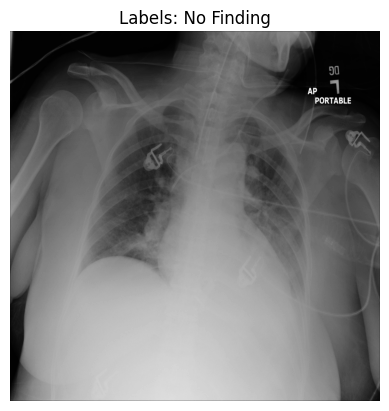

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample(df_split, idx=0):
    row = df_split.iloc[idx]
    img = Image.open(all_img_paths[row['Image Index']])  # update path as necessary
    plt.imshow(img, cmap='gray')
    labels = [lbl for lbl, val in zip(all_labels, row['onehot']) if val]
    plt.title(f"Labels: {', '.join(labels) if labels else 'No Finding'}")
    plt.axis('off')
    plt.show()

# Show a random training example
show_sample(df_train.sample(1))


In [57]:
from torch.utils.data import Dataset, DataLoader
import torch

class ChestXrayDataset(Dataset):
    def __init__(self, df_split, image_dir, transform=None):
        self.df = df_split.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_dir[self.df.iloc[idx]['Image Index']]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # Convert one-hot list to torch tensor
        label = torch.tensor(self.df.iloc[idx]['onehot'], dtype=torch.float32)
        return img, label

# Example transforms (you can add data augmentation here)
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),                # ±10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Mild intensity changes
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet means
                     [0.229, 0.224, 0.225])      # ImageNet stds
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = ChestXrayDataset(df_train, all_img_paths, transform=train_transform)
val_dataset = ChestXrayDataset(df_val, all_img_paths, transform=val_test_transform)
test_dataset = ChestXrayDataset(df_test, all_img_paths, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)



In [58]:
for images, labels in train_loader:
    print("Image batch shape:", images.shape)     # e.g., [batch_size, 3, 224, 224]
    print("Label batch shape:", labels.shape)     # e.g., [batch_size, num_labels]
    print("First 3 label vectors:\n", labels[:3])
    break

Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 15])
First 3 label vectors:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


In [42]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetWithThreeLayerMLP(nn.Module):
    def __init__(self, n_classes=15, backbone='resnet50', mlp_hidden1=512, mlp_hidden2=256):
        super().__init__()
        # Load and freeze pretrained ResNet backbone
        resnet = getattr(models, backbone)(pretrained=True)
        for name,param in resnet.named_parameters():
            param.requires_grad = False
            if "layer4" in name:
                param.requires_grad = True
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC

        # Custom 3-layer MLP head
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(resnet.fc.in_features, mlp_hidden1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(mlp_hidden1, mlp_hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(mlp_hidden2, n_classes)  # No sigmoid here
        )
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.mlp(x)  # Use BCEWithLogitsLoss, applies sigmoid automatically
        return x

# Usage
model = ResNetWithThreeLayerMLP(n_classes=15)


In [59]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=1e-4, weight_decay=1e-4)
  


In [46]:
device

device(type='cuda')

In [60]:
def multilabel_accuracy(preds, targets, threshold=0.5):
    # preds: raw logits
    probs = torch.sigmoid(preds)
    preds_bin = (probs > threshold).float()
    correct = (preds_bin == targets).float()
    # Micro: total correct labels / total labels
    acc = correct.sum() / torch.numel(correct)
    return acc.item()

num_epochs = 10  # Set as needed

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_acc += multilabel_accuracy(outputs.detach(), labels) * images.size(0)
        total_train += images.size(0)
    
    avg_train_loss = train_loss / total_train
    avg_train_acc = train_acc / total_train

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_acc += multilabel_accuracy(outputs, labels) * images.size(0)
            total_val += images.size(0)
    
    avg_val_loss = val_loss / total_val
    avg_val_acc = val_acc / total_val

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc*100:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc*100:.2f}%")


Epoch 1/10: Train Loss: 0.1467, Acc: 94.92% | Val Loss: 0.1602, Acc: 94.46%
Epoch 2/10: Train Loss: 0.1426, Acc: 94.99% | Val Loss: 0.1565, Acc: 94.55%
Epoch 3/10: Train Loss: 0.1415, Acc: 95.01% | Val Loss: 0.1591, Acc: 94.47%
Epoch 4/10: Train Loss: 0.1400, Acc: 95.05% | Val Loss: 0.1553, Acc: 94.62%
Epoch 5/10: Train Loss: 0.1390, Acc: 95.06% | Val Loss: 0.1572, Acc: 94.35%
Epoch 6/10: Train Loss: 0.1367, Acc: 95.11% | Val Loss: 0.1649, Acc: 94.20%
Epoch 7/10: Train Loss: 0.1358, Acc: 95.16% | Val Loss: 0.1590, Acc: 94.43%
Epoch 8/10: Train Loss: 0.1341, Acc: 95.24% | Val Loss: 0.1561, Acc: 94.40%
Epoch 9/10: Train Loss: 0.1325, Acc: 95.27% | Val Loss: 0.1619, Acc: 94.23%
Epoch 10/10: Train Loss: 0.1297, Acc: 95.35% | Val Loss: 0.1664, Acc: 94.54%


In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import torch
model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.cpu().numpy()  # Change to numpy for metric calculation
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_true.append(labels)
        all_pred.append(preds)

# Concatenate results
y_true = np.vstack(all_true)
y_pred = np.vstack(all_pred)


In [62]:
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Test Precision (macro): {precision:.4f}")
print(f"Test Recall (macro): {recall:.4f}")
print(f"Test F1 score (macro): {f1:.4f}")


Test Precision (macro): 0.1217
Test Recall (macro): 0.0676
Test F1 score (macro): 0.0710


In [55]:
print('len(all_labels):', len(all_labels))
print('y_true.shape:', y_true.shape)
print('y_pred.shape:', y_pred.shape)


len(all_labels): 15
y_true.shape: (2864, 15)
y_pred.shape: (2864, 15)


In [65]:
# Fix: Use the properly defined all_labels from earlier
# If you want to sample random test examples:
n_examples = 15
indices = np.random.choice(len(y_true), n_examples, replace=False)

# Use the all_labels that was defined earlier in the notebook (cell [12])
# all_labels = sorted({l for x in df['Finding Labels'] for l in x.split('|')})
print("Available labels:", all_labels)
print("Number of labels:", len(all_labels))

for idx in indices:
    true = [all_labels[i] for i, val in enumerate(y_true[idx]) if val == 1]
    pred = [all_labels[i] for i, val in enumerate(y_pred[idx]) if val == 1]
    print(f"Example {idx+1}")
    print(f"  True Labels: {', '.join(true) if true else 'No '}")
    print(f"  Pred Labels: {', '.join(pred) if pred else 'No '}")
    print("-----")

Available labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Number of labels: 15
Example 3044
  True Labels: Mass
  Pred Labels: No 
-----
Example 2153
  True Labels: No Finding
  Pred Labels: No Finding
-----
Example 2753
  True Labels: No Finding
  Pred Labels: No Finding
-----
Example 1714
  True Labels: Effusion, Infiltration
  Pred Labels: No 
-----
Example 769
  True Labels: Pleural_Thickening
  Pred Labels: No 
-----
Example 2418
  True Labels: No Finding
  Pred Labels: No Finding
-----
Example 2860
  True Labels: Atelectasis, Infiltration
  Pred Labels: No 
-----
Example 3547
  True Labels: Infiltration
  Pred Labels: No Finding
-----
Example 2946
  True Labels: No Finding
  Pred Labels: No Finding
-----
Example 2089
  True Labels: Infiltration, Nodule
  Pred Labels: No Finding
-----
Example 1597
  True Labels: No Find